In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

from simulai.math.differentiation import CollocationDerivative

from simulai.rom import POD
from simulai.io import Reshaper
from simulai.simulation import Pipeline

from pysindy import PolynomialLibrary, FourierLibrary, ConcatLibrary, WeakPDELibrary, STLSQ, SINDyOptimizer, SR3

%matplotlib inline

In [2]:
hf = h5py.File('/Users/properallan/Documents/github/weaksindy/weaksindy/examples/PDE_bench/data/burgers_data', 'r')
data = hf['phi'][:]
x = hf['x'][:]
time = np.linspace(0,2,201)[:]

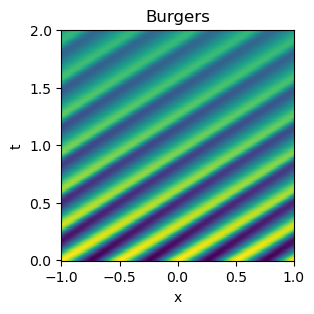

In [3]:
plt.figure(figsize=(3,3))
plt.pcolormesh(x, time, data)
plt.title('Burgers')
plt.ylabel('t')
plt.xlabel('x')
plt.show()

# POD

In [4]:
class orderReduction:
    def __init__(self, rom_config: dict = {} ) -> None:
        self.rom_config = rom_config
        self.input_data = self.rom_config['input_data']
        self.stages = self.rom_config['stages']

        self.pipeline = Pipeline(self.stages)
        self.pipeline.exec(self.input_data)

    def project_data(self, data=None):
        if data is None:
            data = self.input_data
        elif len(data.shape) == 1:
            data = data[None,:]
        return self.pipeline.project_data(data=data)
      

    def reconstruct_data(self, data=None):
        if data is None:
            data = self.projected_data
        elif len(data.shape) == 1:
            data = data[None,:]
        return self.pipeline.reconstruct_data(data=data)

In [5]:
pod_config = {
    'n_components' : 4
}

rom_config = {
    'stages' : [ ('data_preparer', Reshaper()),
                 ('rom', POD(config=pod_config)) ],
    'input_data' :  data,
}

rom = orderReduction(rom_config)

Executing a global pipeline.
Executed operation RESHAPER.
Relative contribution of the mean component: 0.07053456455469131
Relative Modal Energy 0.9971917271614075
Executed operation POD.


In [6]:
from simulai.math.basis import UniformTestFunction, AdaptiveTestFunction, UniformMultiscaleTestFunction
from simulai.regression import WeakSINDy

polynomials = PolynomialLibrary(degree=2)
optimizer = STLSQ(threshold=0.1, alpha=1e-14, max_iter=20)
#test_function = UniformTestFunction(p=16, q=16, L=50, overlap=0.4, ghost_cells=23)

#test_function = UniformTestFunction(p=16, q=16, L=20, overlap=0.4, ghost_cells=0)
#test_function = UniformTestFunction(p=16, q=16, L=8, overlap=0.01, ghost_cells=0)

#test_function = AdaptiveTestFunction(q=16, s=8, K=60, p=2, tau_p=16, r_whm=4)

test_function = UniformMultiscaleTestFunction(p=4, q=4, overlap=0.5, ghost_cells=0)

#Adaptive
#test_function = AdaptiveTestFunction(q=16, r_whm = 8, s = 10 , K = 15, p = 16, tau_p = 1)

wsindy = WeakSINDy(feature_library=polynomials, solver=optimizer, test_function=test_function)
wsindy.scale_theta = 0
wsindy.useGLS = 10**(-12)

In [7]:
pdata = rom.project_data(data)

In [8]:
import sys
import pathlib
sys.path.append(str(pathlib.Path('/Users/properallan/Documents/github/simulai/examples/').resolve()))

from utils.slice_data import sliceDataAlongAxis
from utils.plot import plot_latent

time_trash, time_train, time_validation, time_test = sliceDataAlongAxis(time, [0.0, 0.46, 0.0, 0.54], 0)
pdata_trash, pdata_train, pdata_validation, pdata_test = sliceDataAlongAxis(pdata, [0.0, 0.46, 0.0, 0.54], 0)

UnboundLocalError: local variable 'ramain_added' referenced before assignment

In [ ]:
fig, ax = plot_latent(
    [(time_train, pdata_train), 
     (time_validation, pdata_validation),
     (time_test, pdata_test)] ,
    [dict(label='latent - training'),
     dict(label='latent - validation'),
     dict(label='latent - test')]
)

In [ ]:
wsindy.fit(pdata_train, time_train)

In [ ]:
plt.figure(figsize=(10,2))
plt.plot(wsindy.mats[1][0].T)
plt.show()

In [ ]:
wsindy_derivative = wsindy.predict(pdata)

In [ ]:
from simulai.math.differentiation import CollocationDerivative

diff_config={'step': time[1]-time[0]}
diff = CollocationDerivative(config=diff_config)
collocation_derivative = diff.solve(data=pdata) 

In [ ]:
fig, ax = plot_latent([
             (time, collocation_derivative),
             (time, wsindy_derivative),
             ], 
            [
             dict(label='FD derivatives'),
             dict(label='WSINDy derivatives'),
             ],
             vlines=[ time_train[-1] ],
            vlines_kwargs = [ dict(label='end train', color='k', ls='--') ],
             fig_kwargs=dict(figsize=(10,3.2)))

In [ ]:
wsindy_result, t_wsindy=wsindy.simulate(pdata[0], time, integrator='odeint')

In [ ]:
tend=-1
fig, ax = plot_latent(data = [ (time, pdata),
                               (time, wsindy_result) ], 
                      data_kwargs=[ dict(label='latent'),
                                    dict(label='WSINDy latent')], 
                      vlines=[ time_train[-1] ],
                      vlines_kwargs = [ dict(label='end train', color='k', ls='--') ],
                      fig_kwargs=dict(figsize=(9,4)) )

In [ ]:
from simulai.metrics import L2Norm, PointwiseError
perror = PointwiseError()

wsindy_reconstructed_data = rom.reconstruct_data(data=wsindy_result)
error = perror(data=wsindy_reconstructed_data, reference_data=data)


In [ ]:

fig, ax = plt.subplots(1, 3, figsize=(12,3.5))
datas = [data, wsindy_reconstructed_data, error]
title = ['raw', 'ROM', 'error']

vmin = np.min(data[0])
vmax = np.max(data[0])
for i,axi in enumerate(ax):
    pc = axi.pcolormesh(hf['x'], time, datas[i])
    axi.set_title(title[i])
    axi.set_ylabel('t')
    axi.set_xlabel('x')
    cbar = plt.colorbar(pc)

plt.tight_layout()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_latent( data:list=[], 
                 data_kwargs:list=[], 
                 start_idx=None, 
                 end_idx=None,
                 fig_kwargs=None, 
                 ax=None,
                 vlines=None,
                 vlines_kwargs=None,
                 **kwargs):
    if fig_kwargs is None:
        fig_kwargs = {}
    if vlines_kwargs is None:
        vlines_kwargs = {}

    if 'ncols' not in fig_kwargs.keys():
        fig_kwargs['ncols'] = 2
        
    if data[0][1].shape[1] == 1:
         fig_kwargs['ncols'] = 1

    n_columns = fig_kwargs['ncols']
    n_latent = data[0][1].shape[1]
    if n_latent < n_columns:
        n_columns = n_latent
    n_rows = int(np.ceil(n_latent/n_columns))

    if 'nrows' not in kwargs.keys():
        fig_kwargs['nrows'] = n_rows
    if 'figsize' not in fig_kwargs.keys():
        if n_rows == 1:
            scale = 1.5
        else:
            scale = 1
        fig_kwargs['figsize'] = (7.5*n_columns, n_rows*2*scale)
    if 'colsize' in kwargs.keys():
        fig_kwargs['figsize'] = (kwargs['colsize'], fig_kwargs['figsize'][1])
    if 'rowsize' in kwargs.keys():
        fig_kwargs['figsize'] = (fig_kwargs['figsize'][0], kwargs['rowsize'])

    
    if ax is None:
        fig, ax = plt.subplots( **fig_kwargs )

    try:
        shape_len = len(ax.shape)
        if shape_len == 1:
            ax = np.array([ax])
    except:
        ax = np.array([[ax]])
        
    vv = 0
    for i in  np.arange(n_rows):
        for j in np.arange(n_columns):
            if vv < n_latent:
                for d,l in zip(data, data_kwargs):
                    time = d[0][start_idx:end_idx]
                    variable = d[1][start_idx:end_idx,vv]
                    ax[i][j].plot(time, variable, **l)
                ax[i][j].set_title(rf" Variable $x_{str({vv+1})}$")
                ax[i][j].grid(True)
                if i == (n_rows-1):
                    ax[i][j].set_xlabel('tstep')
                if vlines is not None:
                    for vline, vline_kwargs in zip(vlines, vlines_kwargs):
                        ax[i][j].vlines(vline, *ax[i][j].get_ylim(), **vline_kwargs )
            else:
                ax[i][j].clear()
                plt.axis('off')
            vv += 1

    #fig.legend(bbox_to_anchor=(0, -0.04))
    ax[0][0].legend(loc='lower left', bbox_to_anchor=(-0.02, 1.15), fancybox=True, shadow=True, ncol=2)
    #plt.legend(bbox_to_anchor=(0, -0.04), fancybox=True, shadow=True, borderaxespad=0)
    plt.tight_layout()
    #plt.show()
    return fig, ax

In [ ]:
random_idx=np.random.randint(1024, size=4)
fig, ax = plot_latent(data = [ (time, data[:,random_idx]),
                               (time, wsindy_reconstructed_data[:, random_idx]) ], 
                      data_kwargs=[ dict(label='latent'),
                                    dict(label='WSINDy latent')], 
                      vlines=[ time_train[-1] ],
                      vlines_kwargs = [ dict(label='end train', color='k', ls='--') ],
                      
)